# Laplacian experiment

In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

## Define distribution

In [102]:
dim = 1

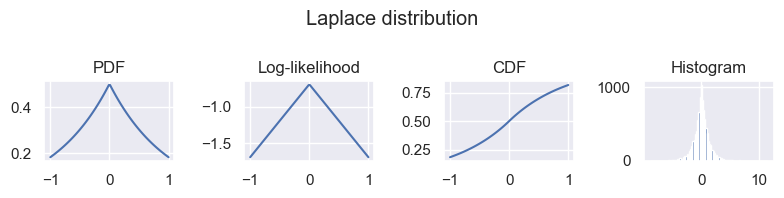

In [103]:
# Sample data points from Laplacian distribution:
# exp(-|x|/b) / (2b)
def sample_laplace(n, b):
    """
    Inputs:
        n: number of points
        b: scale parameter of the Laplacian distribution
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.laplace.Laplace(0, b).sample((n,))
    return x


class LaplaceSampler(object):
    def __init__(self, b):
        self.b = b

    def __call__(self, n):
        return sample_laplace(n, self.b)


b = 1.0
dist = torch.distributions.laplace.Laplace(0, b)
x = LaplaceSampler(b)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-1, 1, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_laplace(10000, b), bins=100)
plt.title("Histogram")
plt.suptitle("Laplace distribution")
plt.tight_layout()

In [104]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

In [105]:
# parameters for laplace distribution
b = 1
sigma_noise = 1.0
sampler = LaplaceSampler(b)

Text(0.5, 1.0, 'Example training points')

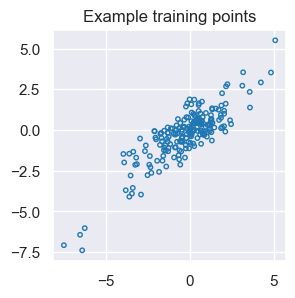

In [106]:
# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")

### Plot function

In [107]:
# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)

    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, soft_thr(xi), "--", label="soft thr.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, np.abs(xi), "--", label=r"$\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()

## Define loss

Text(0.5, 1.0, 'exp loss')

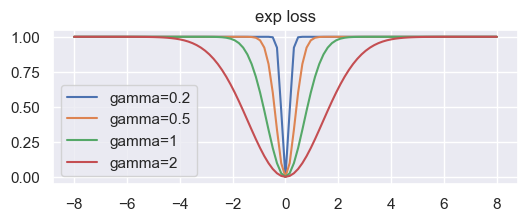

In [108]:
# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1


# visualize the loss at different sigma
plt.rcParams["figure.figsize"] = (6, 2)
x = torch.linspace(-8, 8, 101)
for gamma_exp_loss in [0.2, 0.5, 1, 2]:
    plt.plot(x, exp_func(x, gamma_exp_loss), label="gamma=" + str(gamma_exp_loss))
plt.legend()
plt.grid("on")
plt.title("exp loss")

## Model parameters

In [109]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# create a model
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


## Training function

In [110]:
def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):
    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 1.8206255435943604
iteration 0 loss 18.46721839904785
iteration 500 loss 1.3207753896713257
iteration 1000 loss 0.9839813709259033
iteration 1500 loss 0.9790367484092712
iteration 2000 loss 0.9244794845581055
iteration 2500 loss 0.8209794759750366
iteration 3000 loss 0.7230926752090454
iteration 3500 loss 0.6889854073524475
iteration 4000 loss 0.6748584508895874
iteration 4500 loss 0.663939893245697
iteration 5000 loss 0.6418311595916748
iteration 5500 loss 0.6267200708389282
iteration 6000 loss 0.6113994121551514
iteration 6500 loss 0.6514428853988647
iteration 7000 loss 0.6272854208946228
iteration 7500 loss 0.6111202836036682
iteration 8000 loss 0.5979729294776917
iteration 8500 loss 0.6183955669403076
iteration 9000 loss 0.6287060976028442
iteration 9500 loss 0.6097391843795776
mse 5.344110488891602
mse 3.638723134994507
mse 1.9828518629074097
mse 0.7643046379089355
mse 0.1847415417432785
mse 0.03884474188089371
mse 0.010565494187176228
mse 0.0027935770340263844
ms

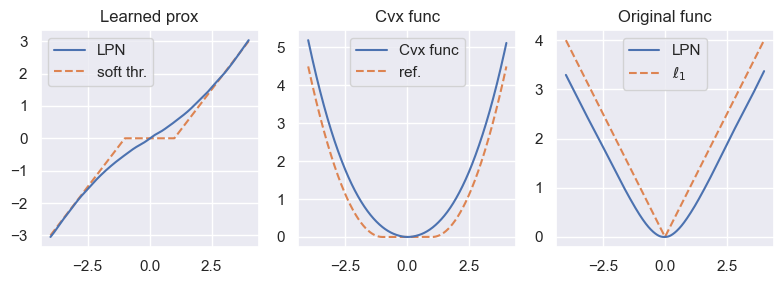

In [111]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(1):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 1.2023749351501465
iteration 500 loss 0.6162778735160828
iteration 1000 loss 0.6042025685310364
iteration 1500 loss 0.6097608804702759
iteration 2000 loss 0.6148138046264648
iteration 2500 loss 0.628761351108551
iteration 3000 loss 0.6145132184028625
iteration 3500 loss 0.628146767616272
iteration 4000 loss 0.641949474811554
iteration 4500 loss 0.6177706718444824
iteration 5000 loss 0.624915599822998
iteration 5500 loss 0.6242783665657043
iteration 6000 loss 0.62385094165802
iteration 6500 loss 0.6127541661262512
iteration 7000 loss 0.6087161898612976
iteration 7500 loss 0.6132732629776001
iteration 8000 loss 0.6292990446090698
iteration 8500 loss 0.6137698292732239
iteration 9000 loss 0.6229090690612793
iteration 9500 loss 0.6245454549789429
iteration 0 loss 0.5951123833656311
iteration 500 loss 0.6435191035270691
iteration 1000 loss 0.6408283114433289
iteration 1500 loss 0.6210001707077026
iteration 2000 loss 0.613248348236084
iteration 2500 loss 0.6224192976951599
i

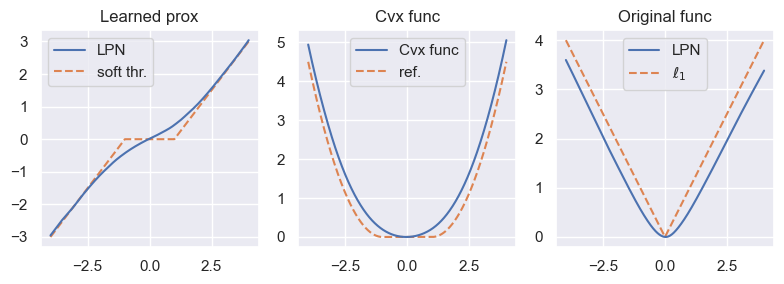

In [112]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

gamma=0.5

iteration 0 loss 0.5765151381492615
iteration 500 loss 0.5680451989173889
iteration 1000 loss 0.5793874263763428
iteration 1500 loss 0.5525346398353577
iteration 0 loss 0.575698971748352
iteration 500 loss 0.5865528583526611
iteration 1000 loss 0.586010754108429
iteration 1500 loss 0.562116265296936
mse 5.3440985679626465
mse 4.129190921783447
mse 1.4286144971847534
mse 0.3342820703983307
mse 0.07451539486646652
mse 0.017035720869898796
mse 0.0030212351121008396
mse 0.0004423029604367912
mse 6.006904732203111e-05
mse 7.4354147727717645e-06
final mse 8.225933925132267e-07
(1000,) (1000,) (1000,) (1000,)


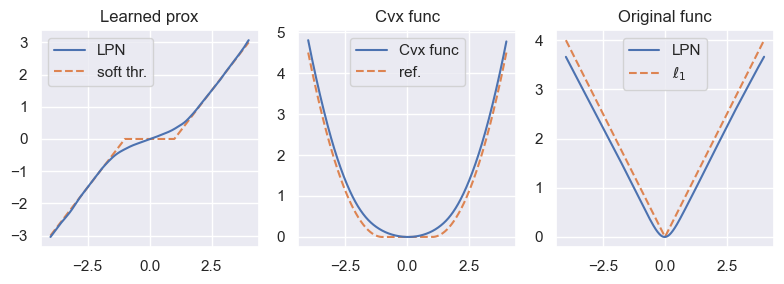

In [113]:
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

iteration 0 loss 0.650799572467804
iteration 500 loss 0.6313424110412598
iteration 1000 loss 0.6397321820259094
iteration 1500 loss 0.6464909315109253
iteration 2000 loss 0.6534952521324158
iteration 2500 loss 0.6308785676956177
iteration 3000 loss 0.6519395112991333
iteration 3500 loss 0.6387092471122742
mse 5.344033718109131
mse 4.257127285003662
mse 1.232551097869873
mse 0.2759394645690918
mse 0.06580004096031189
mse 0.024892663583159447
mse 0.008150803856551647
mse 0.0021056223195046186
mse 0.0004621356201823801
mse 8.787507977103814e-05
final mse 1.474224882258568e-05
(1000,) (1000,) (1000,) (1000,)


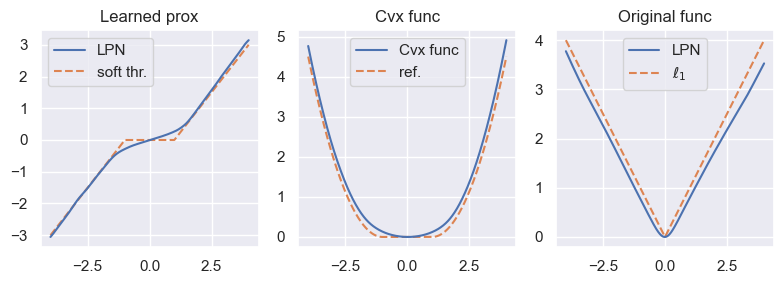

In [114]:
gamma_loss = 0.4
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

iteration 0 loss 0.722200334072113
iteration 500 loss 0.7222797870635986
iteration 1000 loss 0.7252203822135925
iteration 1500 loss 0.7293280363082886
iteration 2000 loss 0.714059591293335
iteration 2500 loss 0.7253824472427368
iteration 3000 loss 0.7200450897216797
iteration 3500 loss 0.7093183994293213
mse 5.3440117835998535
mse 4.396421909332275
mse 1.287996768951416
mse 0.3039533793926239
mse 0.10320324450731277
mse 0.03745604678988457
mse 0.009412205778062344
mse 0.0019013861892744899
mse 0.00036701190401799977
mse 6.60036166664213e-05
final mse 1.0649212526914198e-05
(1000,) (1000,) (1000,) (1000,)


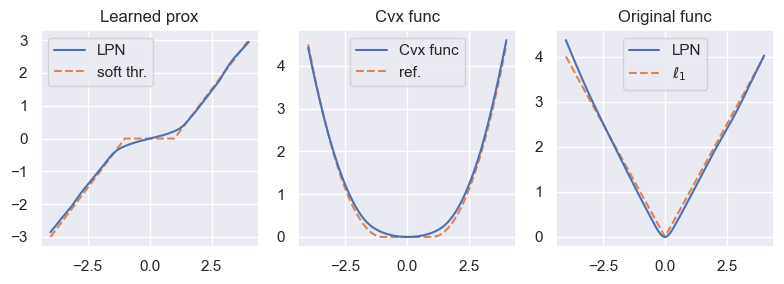

In [115]:
gamma_loss = 0.3
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

iteration 0 loss 0.8129734396934509
iteration 500 loss 0.8108572959899902
iteration 1000 loss 0.8000860810279846
iteration 1500 loss 0.8128869533538818
iteration 2000 loss 0.8053463697433472
iteration 2500 loss 0.8000937700271606
iteration 3000 loss 0.8112757802009583
iteration 3500 loss 0.796453595161438
mse 5.344010829925537
mse 4.421658039093018
mse 1.0553747415542603
mse 0.24760153889656067
mse 0.07447585463523865
mse 0.021801922470331192
mse 0.004205784760415554
mse 0.0006495910929515958
mse 9.206622780766338e-05
mse 1.1975127563346177e-05
final mse 1.423790308763273e-06
(1000,) (1000,) (1000,) (1000,)


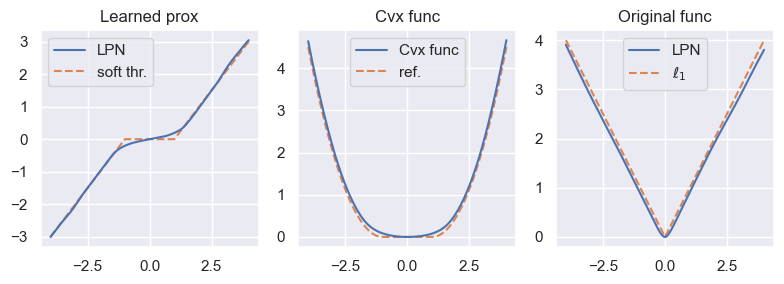

In [116]:
gamma_loss = 0.2
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.1

iteration 0 loss 0.8975762724876404
iteration 500 loss 0.9090964198112488
iteration 1000 loss 0.9089913368225098
iteration 1500 loss 0.8995524644851685
iteration 2000 loss 0.9104628562927246
iteration 2500 loss 0.8983585238456726
iteration 3000 loss 0.8931257724761963
iteration 3500 loss 0.8954382538795471
iteration 0 loss 0.8932904601097107
iteration 500 loss 0.8920523524284363
iteration 1000 loss 0.896261990070343
iteration 1500 loss 0.8998103737831116
iteration 2000 loss 0.9038011431694031
iteration 2500 loss 0.9040761590003967
iteration 3000 loss 0.8893687725067139
iteration 3500 loss 0.9015840888023376
mse 5.3440260887146
mse 4.527210712432861
mse 0.979777991771698
mse 0.2206803262233734
mse 0.06885464489459991
mse 0.020970342680811882
mse 0.0037929911632090807
mse 0.000499660731293261
mse 5.634515764540993e-05
mse 5.600409622275038e-06
final mse 4.955512622473179e-07
(1000,) (1000,) (1000,) (1000,)


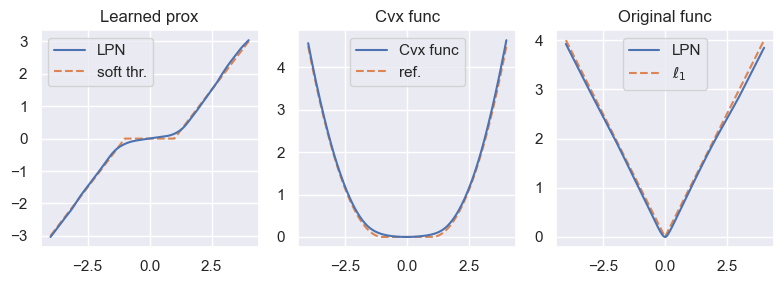

In [117]:
gamma_loss = 0.1
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)